In [2]:
# from moku.instruments import PIDController
# from moku.instruments import Oscilloscope
from numpy import sqrt, pi, array, arange, polyfit
from scipy import optimize
# from sympy import *

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import datetime

%matplotlib notebook

In [17]:
pip install sympy

  Using cached mpmath-1.2.1-py3-none-any.whl (532 kB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
4.51 / 5

0.9019999999999999

## Pressure conversion

In [2]:
def con_pv(voltage):
    return 10**((voltage-7.75)/0.75)

In [3]:
con_pv(2.527)

1.0864256236170667e-07

## MOKU:GO oscilloscopy

In [ ]:
# This example demonstrates how you can configure the Oscilloscope instrument,
# and view triggered time-voltage data frames in real-time.
#
# (c) 2021 Liquid Instruments Pty. Ltd.

print('START : ' + datetime.datetime.now().strftime("%d/%m/%Y, %H:%M:%S"))
def on_close(event):
    print('Closed Figure!')
    i.relinquish_ownership()
    
# Connect to your Moku by its ip address using Oscilloscope('192.168.###.###')
# or by its serial number using Oscilloscope(serial=123)
i = Oscilloscope('129.206.180.142', force_connect=True)

try:
    # Trigger on input Channel 1, rising edge, 0V 
    i.set_trigger(type='Edge', source='Input1', level=0)

    # View +-5usec, i.e. trigger in the centre
    i.set_timebase(-5e-6, 5e-6)

    # Generate an output sine wave on Channel 1, 1Vpp, 1MHz, 0V offset
    # i.generate_waveform(1, 'DC', amplitude=1)
    # i.generate_waveform(2, 'Sine', amplitude=1, frequency=1e6)

    # Set the data source of Channel 1 to be Input 1
    i.set_source(1, 'Input1')

    # Set the data source of Channel 2 to the generated output sinewave
    i.set_source(2, 'Input2')


    # Get initial data frame to set up plotting parameters. This can be done
    # once if we know that the axes aren't going to change (otherwise we'd do
    # this in the loop)
    data = i.get_data()
    print(data.keys())

    # Set up the plotting parameters
    plt.ion()
    plt.show()
    plt.grid(b=True)
    plt.ylim([-1, 1])
    plt.xlim([data['time'][0], data['time'][-1]])

    line1, = plt.plot([], label='channel 1')
    line2, = plt.plot([], label='channel 2')

    # Configure labels for axes
    ax = plt.gca()
    
    # This loops continuously updates the plot with new data
    while True:
        # Get new data
        data = i.get_data()

        # Update the plot
        line1.set_ydata(data['ch1'])
        line2.set_ydata(data['ch2'])
        line1.set_xdata(data['time'])
        line2.set_xdata(data['time'])
        
        ax.set_title(datetime.datetime.now().strftime("%d/%m/%Y, %H:%M:%S"))
        ax.legend()

        plt.pause(0.001)
        
        fig = plt.gcf()  # get current figure
        fig.canvas.mpl_connect('close_event', on_close)
        
except Exception as e:
    print(f'Exception occurred: {e}')
except KeyboardInterrupt:
    print('Interrupt!')
finally:
    # Close the connection to the Moku device
    # This ensures network resources and released correctly
    i.relinquish_ownership()
    print('Ownership relinquished!')

In [ ]:
i.relinquish_ownership()

## Power calibration

In [36]:
# define functions for fitting
def exp(x, a, c, t):
    return a * np.exp(t * x) + c

[ 0.86601486 -0.87979241  0.61053745]


<IPython.core.display.Javascript object>


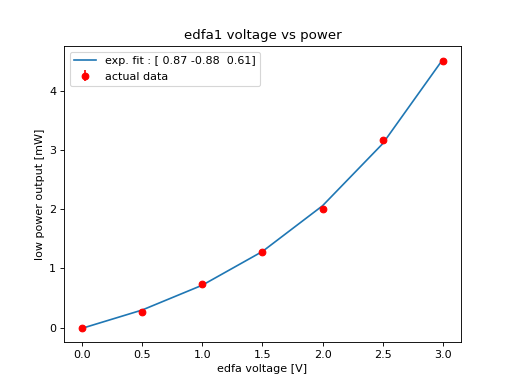

[-0.01377754  0.29538077  0.71490538  1.28419591  2.05671725  3.10502069
  4.52755755]


In [37]:
edfa = np.arange(0, 3.1, 0.5)
power_low = np.array([0,0.27,0.74,1.28,2.01,3.16,4.51])
perr = np.array([0.01]*7)

popt, pcov = optimize.curve_fit(exp, edfa, power_low, sigma=perr, p0=[0.9, 1, -0.5])
label = 'exp. fit : ' + str(np.round(popt,2))
print(popt)

fig, ax = plt.subplots()

ax.errorbar(edfa, power_low, yerr=perr, fmt='ro', label='actual data')
ax.plot(edfa, exp(edfa, *popt), label=label)
print(exp(edfa, *popt),)

ax.set_title('edfa1 voltage vs power')
ax.set_xlabel('edfa voltage [V]')
ax.set_ylabel('low power output [mW]')
ax.legend()

[ 0.17320297 -0.17595847  0.61053746]


<IPython.core.display.Javascript object>


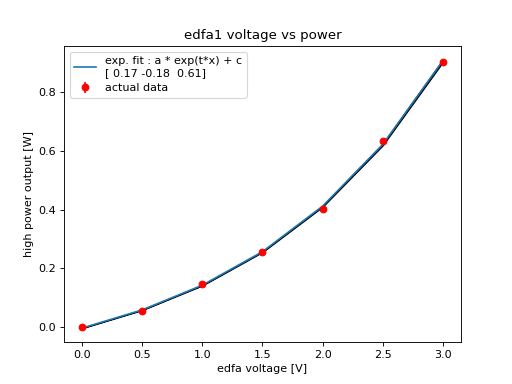

[0.00028171 0.00048394 0.00072357]
[-0.00275551  0.00507615 -0.00501893  0.00083918  0.00934345 -0.01099586
  0.00351151]


In [61]:
edfa = np.arange(0, 3.1, 0.5)
power_high = np.array([0,0.27,0.74,1.28,2.01,3.16,4.51]) / 5
perr = np.array([0.01]*7) / 5

popt, pcov = optimize.curve_fit(exp, edfa, power_high, sigma=perr, p0=[0.5, -1, -0.2])
label = 'exp. fit : a * exp(t*x) + c\n' + str(np.round(popt,2))
print(popt)

fig, ax = plt.subplots()

error = np.diagonal(pcov)
print(error)
pmax = popt + np.array([0.00028171, 0.00048394, 0.00072357])
pmin = popt - np.array([0.00028171, 0.00048394, 0.00072357])

ax.errorbar(edfa, power_high, yerr=perr, fmt='ro', label='actual data')
ax.plot(edfa, exp(edfa, *popt), label=label)
ax.fill_between(edfa, exp(edfa, *pmax), exp(edfa, *pmin), color='k')
print(exp(edfa, *popt)-power_high)

ax.set_title('edfa1 voltage vs power')
ax.set_xlabel('edfa voltage [V]')
ax.set_ylabel('high power output [W]')
ax.legend()

In [32]:
def voltage_to_power(voltage):
	p =  [ 0.17320297, -0.17595848, -0.61053745]
	return p[0] * np.exp( - p[2] * voltage ) + p[1]
	
def power_to_voltage(power):
	p =  [ 0.17320297, -0.17595848, -0.61053745]
	return - np.log( ( power - p[1] ) / p[0] ) / p[2]

In [34]:
voltage_to_power( power_to_voltage (1))
print(voltage_to_power(power_high))

[-0.00275551  0.00305     0.01362391  0.02654594  0.04542584  0.078802
  0.12445774]


# PDmon calibration

[0.45106464 8.10074837] [[ 3.65098271e-05 -7.32282821e-03]
 [-7.32282821e-03  2.45316841e+00]]


<IPython.core.display.Javascript object>


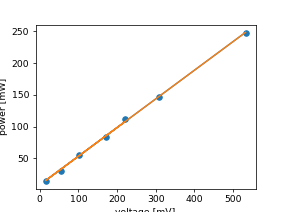

Text(0, 0.5, 'power [mW]')

In [3]:
v = np.array([220,54,15,103,171,308,533])
p = np.array([112,30,14,56,84,147,247])

def lin(x, a, b):
    return x*a + b

popt, pcov = optimize.curve_fit(lin, v, p)
# popt = np.polyfit(v, p, 1)
print(popt, pcov)

fig, ax = plt.subplots()

ax.scatter(v,p)
ax.plot(v, popt[1]+v*popt[0])
ax.plot(v, lin(v, *popt))

ax.set_xlabel('voltage [mV]')
ax.set_ylabel('power [mW]')

[0.45106464 8.10074837] [[ 3.65098271e-05 -7.32282821e-03]
 [-7.32282821e-03  2.45316841e+00]]


<IPython.core.display.Javascript object>


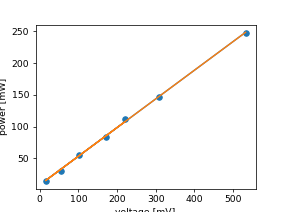

Text(0, 0.5, 'power [mW]')

In [14]:
v = np.array([220,54,15,103,171,308,533])
p = np.array([112,30,14,56,84,147,247])

def lin(x, a, b):
    return x*a + b

popt, pcov = optimize.curve_fit(lin, v, p)
# popt = np.polyfit(v, p, 1)
print(popt, pcov)

fig, ax = plt.subplots()

ax.scatter(v,p)
ax.plot(v, popt[1]+v*popt[0])
ax.plot(v, lin(v, *popt))

ax.set_xlabel('voltage [mV]')
ax.set_ylabel('power [mW]')

<IPython.core.display.Javascript object>


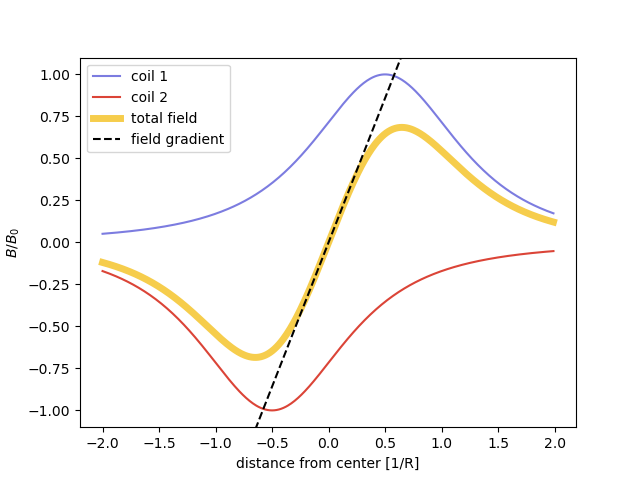

In [49]:
x = Symbol('x')
X = np.arange(-2,2,0.01)
r = 1
o = r/2
i = 1

purple = '#7c7ce0ff'; yellow = '#f6cd4c'; red = '#db4437'

def B(x, I, R, off):
    return I/2 * R**2/(R**2 + (x-off)**2)**(3/2)

def total(x):
    return 1.0*(1.5 - 3.0*x)/((x - 0.5)**2 + 1)**2.5 - 1.0*(-3.0*x - 1.5)/((x + 0.5)**2 + 1)**2.5

B0 = B(0,1,1,0)
f = (B(x,i,r,o)-B(x,i,r,-o))/B0
# print(f.diff())

plt.plot(X, B(X,i,r,o)/B0, label="coil 1", color=purple)
plt.plot(X, -B(X,i,r,-o)/B0, label="coil 2", color=red)
plt.plot(X, (B(X,i,r,o)-B(X,i,r,-o))/B0, label="total field", linewidth='5', color=yellow)
plt.plot(X, total(0)*X, label='field gradient', linestyle='--', color='k')

plt.ylim(-1.1, 1.1)
plt.ylabel(r'$B/B_0$')
plt.xlabel('distance from center [1/R]')
plt.legend()